## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0]

294478

In [4]:
df['user_id'].nunique()

290584

In [5]:
df['converted'].mean()

0.11965919355605512

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2['user_id'].nunique()

290584

In [11]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2.drop_duplicates('user_id',inplace=True)

In [14]:
df2.query('converted == 1')['user_id'].nunique()/df2['user_id'].nunique()

0.11959708724499628

In [15]:
p_con = df2.query('group=="control" and converted==1')['user_id'].nunique()/df2.query('group=="control"')['user_id'].nunique()
p_con

0.1203863045004612

In [16]:
p_treat = df2.query('group == "treatment" and converted == 1')['user_id'].nunique()/df2.query('group == "treatment"')['user_id'].nunique()
p_treat

0.11880806551510564

In [17]:
df.query('landing_page == "new_page"')['user_id'].nunique()/df['user_id'].nunique()

0.5035273793464197

In [18]:
df.query('group == "control"')['user_id'].nunique()

146195

In [19]:
df.query('group == "treatment"')['user_id'].nunique()

146284

#### According to the analysis upto now,we can state that the conversion rate of the cotrol group is approximately 12.03.It indicates that the probabiltity that person buys a product from the ecommerce store using the old page is 12.03.The conversion rate for the treatment group is 11.88.This means that out of 100% customers that view the new page have a 11.88% tendency to buy a product.As we can see that,The conversion rate for the new page is lower as compared to the old page and hence we must continue with the old page.Besides this,The difference is not much significant and if we add the new page,It won't drive additional sales. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  



#### Null Hypothesis :For the consideration that the old page is better than the new page we can form the Null and the Alternative Hypothesis as  follows : 
#### Null Hypothesis : $p_{old}$ >= $p_{new}$
#### Alternative Hypothesis : $p_{old}$ < $p_{new}$

**Put your answer here.**

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [22]:
n_new = df2.query('group=="treatment"')['user_id'].count()
n_new

145310

In [24]:
n_old = df2.query('group=="control"')['user_id'].count()
n_old

145274

In [25]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new),p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old),p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.00032553967415234475

In [28]:
diffs = []
for _ in range(10000):
    pr_new = np.random.choice([0,1], size=n_new, p=[(1-p_new),p_new])
    pr_old = np.random.choice([0,1], size=n_old, p=[(1-p_old),p_old])
    diffs.append(pr_new.mean() - pr_old.mean())

In [29]:
obs_diff = p_treat - p_con
obs_diff

-0.0015782389853555567

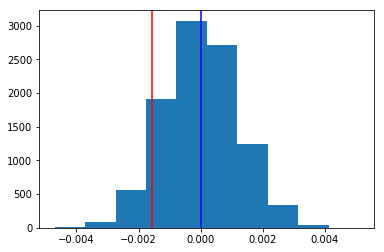

In [30]:
plt.hist(diffs)
plt.axvline(obs_diff,color='red')
plt.axvline(0.0,color='blue')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
diffs = np.array(diffs)

In [32]:
(diffs > obs_diff).mean()

0.90859999999999996

#### The value that we calculated in the j part is called the p value.It implies that the result that we get in the diffs array is how much likely if the null hypothesis is true.The p value is 0.5062 which is way greater than 0.05 i.e Type 1 error probability and hence we can say that we fail to reject the null hypothesis.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group=="control" and converted==1')['converted'].count()
convert_new = df2.query('group=="treatment" and converted==1')['converted'].count()
n_old = len(df2['group'] == "control")
n_new = len(df2['group'] == "treatment")

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [34]:
sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')

(1.2447321532209403, 0.89338488860036569)

#### From the z score obtained we can assume that the z score is smaller than the critical value and hence It is in the favour of accepting the null hypothesis.Besides this,the p value obtained is 0.89 which is approximately equal to the p value we calculated using the sampling distribution.Hence the parts j and k are in correspondance with our calculated values.As stated earlier we would fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### The regression that we would use is the Logistic regression because we have only 2 outcomes that can be treated as categorical variables.

In [38]:
df2['intercept'] = 1

In [35]:

dummy = pd.get_dummies(df['group'])
dummy.drop('control',inplace=True,axis=1)
dummy.columns = ['ab_page']
df2 = df2.join(dummy)


In [36]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0


In [39]:
ln = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res = ln.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-28 13:59 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

#### Our hypothesis here is:
#### $H_{0}$ : $p_{new}$ - $p_{old}$ = 0
#### $H_{1}$ : $p_{new}$ - $p_{old}$ != 0

#### The p value obtained is 0.1899 which is greater than 0.05 and hence we can say that the ab_page attribute or the control group is not significant in predicting the conversion.

#### Yes,Discussing other factors can be really advantageous in predicting a particular statistic.In our example,we need to predict the conversion and more factors need to be considered other than the groups.

#### We need to consider all the attributes that can be statistically significant in predicting our desired attribute.A failure in doing so can result in missing a significant factor for prediction and we would fail to get accurate insights.

#### The more attributes we consider in our analysis we can probably figure out all the factors that round up to a conversion.

In [41]:
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
new_df = country_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
new_df.head(1)

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1


In [43]:
dummies = pd.get_dummies(new_df['country'])
new_df = new_df.join(dummies)
new_df.head(1)

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0


In [44]:
ln = sm.Logit(new_df['converted'],new_df[['intercept','US','UK']])
res = ln.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-28 14:01 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
==================================================================

"""

#### We can see that the p values for the countries are way above 0.05 and hence,we can say that the countries are not significantly important as their p values are way greater than 0.05.Thus,We continue our decision i.e we fail to reject the null hypothesis.

In [45]:
new_df['US_page'] = new_df['US'] * new_df['ab_page']
new_df['UK_page'] = new_df['UK'] * new_df['ab_page']
new_df.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,US_page,UK_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [46]:
ln = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'US', 'UK', 'US_page', 'UK_page']])
res = ln.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-28 14:01 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

#### None of the variables have a significant value below 0.05 and hence we fail to reject the null hypothesis.

#### Considering all the tests we considered,We can say that the new page that the organization needs to add is not suitable for conversions and the organization must try and create a better version of the page.

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0